In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import git

np.random.seed(19680801)
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [ ]:
# Credit: https://stackoverflow.com/questions/5040797/shuffling-numpy-array-along-a-given-axis
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

In [ ]:
encode_supp = pd.read_csv(os.path.join(git_root, "output", "encode_supp_percent_by_region.csv"), index_col=0)
encode_filtered = pd.read_csv(os.path.join(git_root, "output", "encode_filtered_percent_by_region.csv"), index_col=0)
encode_filtered_downsampled = pd.read_csv(os.path.join(git_root, "output", "encode_filtered_downsampled_percent_by_region.csv"), index_col=0)
spidr = pd.read_csv(os.path.join(git_root, "output", "spidr_percent_by_region.csv"), index_col=0)

In [ ]:
def shuffle_impute(df1, df2, samples=1000):
    # Find true difference
    true_diff = np.matrix.flatten(df1.to_numpy() - df2.to_numpy())
    true_norm = np.linalg.norm(true_diff, ord=2)

    # create list to store distribution
    distribution = []
    df1_array = np.matrix.flatten(df1.to_numpy())
    
    for _ in range(samples):
        # Store copy of df2 as numpy array
        df2_np = df2.to_numpy()
        
        # Shuffle and calculate norm
        shuffled = shuffle_along_axis(df2_np, axis=1)
        df2_shuffled_array = np.matrix.flatten(shuffled)
        shuffled_norm = np.linalg.norm(df1_array - df2_shuffled_array)
        distribution.append(shuffled_norm)

    return true_norm, distribution

In [40]:
def imputation_hist(distribution, true_val, name, ax):
    ax.hist(distribution, bins=40)
    ax.axvline(true_val, color='k', linestyle='dashed', linewidth=1, label='Observed L2 Norm')
    ax.set_ylabel("L2 Norm")
    ax.set_title(name)
    ax.legend(loc='upper right')

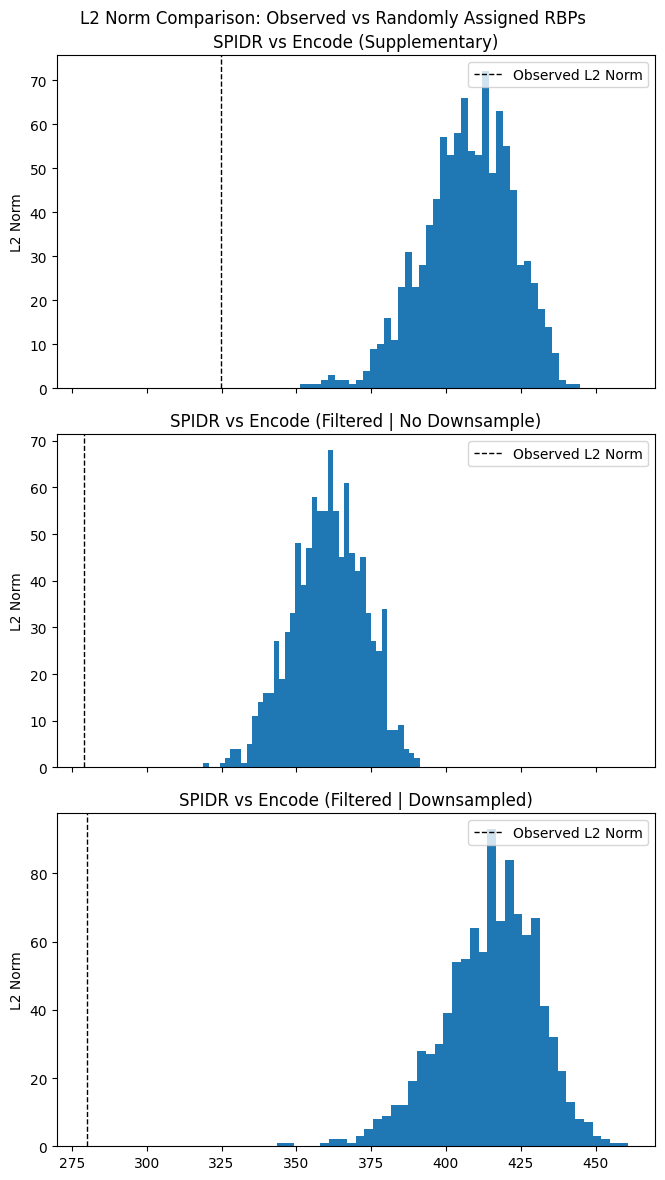

In [43]:
fig, ax = plt.subplots(3,1, sharex=True)
scale = 1.5
fig.set_size_inches(4.5 * scale, 8 * scale)

true_norm, dist = shuffle_impute(spidr, encode_supp)
imputation_hist(dist, true_norm, name="SPIDR vs Encode (Supplementary)", ax=ax[0])

true_norm, dist = shuffle_impute(spidr, encode_filtered)
imputation_hist(dist, true_norm, name="SPIDR vs Encode (Filtered | No Downsample)", ax=ax[1])

true_norm, dist = shuffle_impute(spidr, encode_filtered_downsampled)
imputation_hist(dist, true_norm, name="SPIDR vs Encode (Filtered | Downsampled)", ax=ax[2])

fig.suptitle("L2 Norm Comparison: Observed vs Randomly Assigned RBPs")
fig.tight_layout()
fig.savefig(os.path.join(git_root, "figures", "l2-norm-comparison-shuffle-imputation.png"))